Warmup:   0%|          | 0/1600 [00:00, ?it/s]

Sample: 100%|██████████| 1600/1600 [00:45, 35.38it/s, step size=2.55e-10, acc. prob=0.905]


mu_samps shape: (800, 1, 600)
sigma_samps shape: (800, 1, 600)
mu_pred shape: (600,)
ale_var shape: (600,)
epi_var shape: (600,)
tot_var shape: (600,)


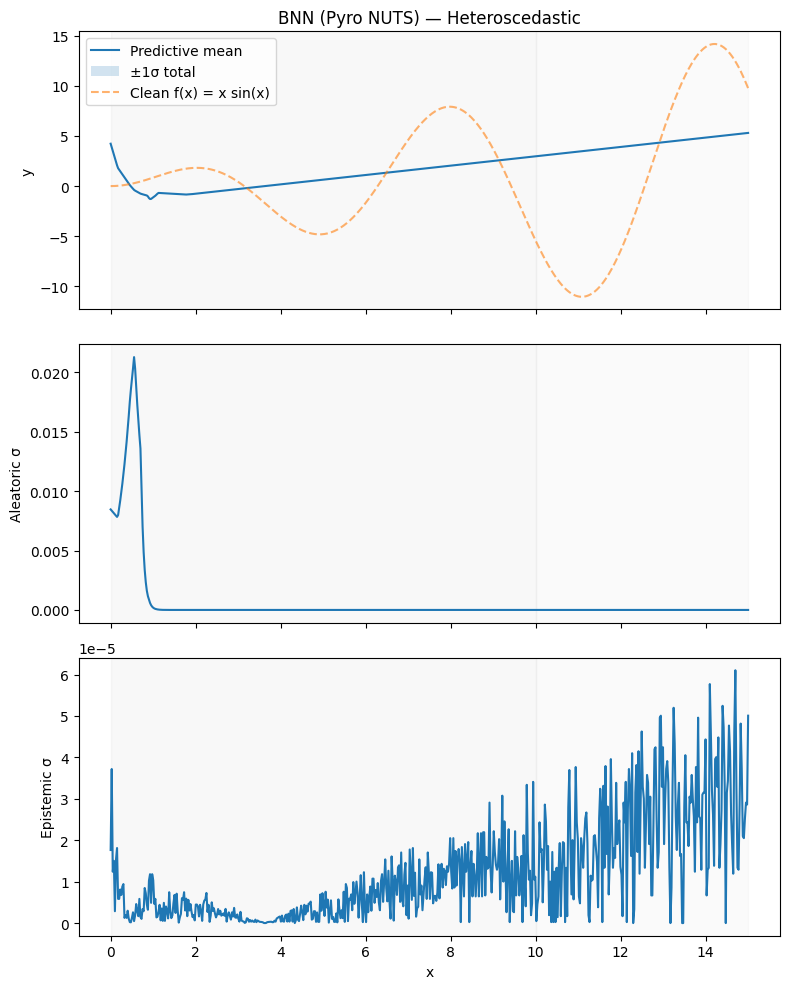

In [4]:
# PyTorch + Pyro BNN with NUTS MCMC for sinusoidal toy regression
# Heteroscedastic likelihood: y ~ Normal(mu(x), sigma(x)), sigma(x) via Softplus
# Decomposition: aleatoric = E[sigma^2], epistemic = Var(mu) across posterior samples

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive

pyro.set_rng_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Data (paper setup) ----------
def generate_toy_regression(n_train=1000, train_range=(0.0, 10.0), ood_range=(10.0, 15.0), grid_points=600, seed=0):
    rng = np.random.default_rng(seed)
    low, high = train_range
    x_train = rng.uniform(low, high, size=(n_train, 1))
    eps1 = rng.normal(0.0, 0.3, size=(n_train, 1))
    eps2 = rng.normal(0.0, 0.3, size=(n_train, 1))
    y_train = x_train * np.sin(x_train) + eps1 * x_train + eps2

    x_grid = np.linspace(train_range[0], ood_range[1], grid_points).reshape(-1, 1)
    y_clean = x_grid * np.sin(x_grid)
    ood_mask = (x_grid[:, 0] > train_range[1])

    return (x_train.astype(np.float32), y_train.astype(np.float32),
            x_grid.astype(np.float32), y_clean.astype(np.float32), ood_mask)

# ---------- Model ----------
def forward_nn(x, W1, b1, W2, b2, W_mu, b_mu, W_rho, b_rho):
    # x: [N,1]; all params are tensors
    h1 = F.relu(x @ W1 + b1)           # [N,H]
    h2 = F.relu(h1 @ W2 + b2)          # [N,H]
    mu = h2 @ W_mu + b_mu              # [N,1]
    rho = h2 @ W_rho + b_rho           # [N,1]
    sigma = F.softplus(rho) + 1e-6     # [N,1], positive std
    return mu.squeeze(-1), sigma.squeeze(-1)

def bnn_model(x, y=None, hidden_width=16, weight_scale=1.0):
    N = x.shape[0]
    H = hidden_width

    # Priors on weights/biases (Gaussian)
    W1   = pyro.sample("W1",   dist.Normal(0, weight_scale).expand([1, H]).to_event(2))
    b1   = pyro.sample("b1",   dist.Normal(0, weight_scale).expand([H]).to_event(1))
    W2   = pyro.sample("W2",   dist.Normal(0, weight_scale).expand([H, H]).to_event(2))
    b2   = pyro.sample("b2",   dist.Normal(0, weight_scale).expand([H]).to_event(1))
    W_mu = pyro.sample("W_mu", dist.Normal(0, weight_scale).expand([H, 1]).to_event(2))
    b_mu = pyro.sample("b_mu", dist.Normal(0, weight_scale).expand([1]).to_event(1))
    W_rho= pyro.sample("W_rho",dist.Normal(0, weight_scale).expand([H, 1]).to_event(2))
    b_rho= pyro.sample("b_rho",dist.Normal(0, weight_scale).expand([1]).to_event(1))

    mu, sigma = forward_nn(x, W1, b1, W2, b2, W_mu, b_mu, W_rho, b_rho)  # [N], [N]
    pyro.deterministic("mu",   mu)
    pyro.deterministic("sigma",sigma)

    with pyro.plate("data", N):
        pyro.sample("obs", dist.Normal(mu, sigma), obs=y if y is not None else None)

# ---------- MCMC ----------
def run_nuts(x_train_t, y_train_t, hidden_width=16, weight_scale=1.0,
             warmup=800, samples=800, chains=1):
    nuts_kernel = NUTS(bnn_model, target_accept_prob=0.8)
    # older Pyro API uses warmup_steps
    mcmc = MCMC(nuts_kernel, num_samples=samples, warmup_steps=warmup, num_chains=chains)
    mcmc.run(x=x_train_t, y=y_train_t, hidden_width=hidden_width, weight_scale=weight_scale)
    return mcmc

def posterior_predictive(mcmc, x_new_t, hidden_width=16, weight_scale=1.0):
    samples = mcmc.get_samples()
    predictive = Predictive(bnn_model, posterior_samples=samples, return_sites=("mu","sigma","obs"))
    preds = predictive(x=x_new_t, hidden_width=hidden_width, weight_scale=weight_scale)
    return {k: v.detach().cpu().numpy() for k, v in preds.items()}

# ---------- Decomposition ----------
def decompose_uncertainty(mu_samples, sigma_samples):
    # Handle potential extra dimensions from Pyro
    if mu_samples.ndim > 2:
        mu_samples = mu_samples.squeeze()
    if sigma_samples.ndim > 2:
        sigma_samples = sigma_samples.squeeze()
    
    # Ensure we have [S,N] shape
    if mu_samples.ndim == 1:
        mu_samples = mu_samples.reshape(1, -1)
    if sigma_samples.ndim == 1:
        sigma_samples = sigma_samples.reshape(1, -1)
    
    # mu_samples: [S,N], sigma_samples: [S,N]
    aleatoric_var = (sigma_samples**2).mean(axis=0)   # E[σ²]
    epistemic_var = mu_samples.var(axis=0)            # Var[μ]
    total_var = aleatoric_var + epistemic_var
    mu_mean = mu_samples.mean(axis=0)
    return mu_mean, aleatoric_var, epistemic_var, total_var

# ---------- Plot ----------
def plot_uncertainties(x_grid, y_clean, mu_pred, ale_var, epi_var, tot_var, title="BNN (Pyro NUTS)"):
    fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)
    x = x_grid[:, 0]

    axes[0].plot(x, mu_pred, label="Predictive mean")
    axes[0].fill_between(x, mu_pred - np.sqrt(tot_var), mu_pred + np.sqrt(tot_var), alpha=0.2, label="±1σ total")
    axes[0].plot(x, y_clean[:, 0], linestyle='--', alpha=0.6, label="Clean f(x) = x sin(x)")
    axes[0].set_ylabel("y"); axes[0].set_title(title); axes[0].legend(loc="upper left")

    axes[1].plot(x, np.sqrt(ale_var)); axes[1].set_ylabel("Aleatoric σ")
    axes[2].plot(x, np.sqrt(epi_var)); axes[2].set_ylabel("Epistemic σ"); axes[2].set_xlabel("x")

    for ax in axes:
        ax.axvspan(x.min(), 10.0, alpha=0.05, color='gray')
        ax.axvspan(10.0, x.max(), alpha=0.10, color='lightgray')

    plt.tight_layout(); plt.show()

# ---------- Main ----------
def main():
    x_train, y_train, x_grid, y_clean, _ = generate_toy_regression(n_train=1000, seed=0)

    x_train_t = torch.from_numpy(x_train).to(device)
    y_train_t = torch.from_numpy(y_train.squeeze(-1)).to(device)
    x_grid_t  = torch.from_numpy(x_grid).to(device)

    hidden_width = 16     # increase to 32 if you have more compute
    weight_scale = 1.0
    warmup = 800
    samples = 800
    chains = 1

    mcmc = run_nuts(x_train_t, y_train_t, hidden_width, weight_scale, warmup, samples, chains)
    preds = posterior_predictive(mcmc, x_grid_t, hidden_width, weight_scale)
    mu_samps = preds["mu"]       # [S,N]
    sigma_samps = preds["sigma"] # [S,N]
    
    # Debug: print shapes
    print(f"mu_samps shape: {mu_samps.shape}")
    print(f"sigma_samps shape: {sigma_samps.shape}")

    mu_pred, ale_var, epi_var, tot_var = decompose_uncertainty(mu_samps, sigma_samps)
    
    # Debug: print final shapes
    print(f"mu_pred shape: {mu_pred.shape}")
    print(f"ale_var shape: {ale_var.shape}")
    print(f"epi_var shape: {epi_var.shape}")
    print(f"tot_var shape: {tot_var.shape}")
    plot_uncertainties(x_grid, y_clean, mu_pred, ale_var, epi_var, tot_var, title="BNN (Pyro NUTS) — Heteroscedastic")

if __name__ == "__main__":
    main()
